In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import random

data_dir = "cv_p3_images_split"
train_gray_dir = os.path.join(data_dir, "train/grayscale")
train_color_dir = os.path.join(data_dir, "train/colored")
val_gray_dir = os.path.join(data_dir, "validation/grayscale")
val_color_dir = os.path.join(data_dir, "validation/colored")

IMG_HEIGHT, IMG_WIDTH = 256, 256

def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size, color_mode="rgb")
    image = img_to_array(image) / 255.0
    return image

def load_images_from_folder(folder, target_size):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        images.append(preprocess_image(img_path, target_size))
    return np.array(images)

def load_dataset(gray_folder, color_folder, target_size, fraction=1.0):
    gray_images = []
    color_images = []
    
    filenames = os.listdir(gray_folder)
    if fraction < 1.0:
        filenames = random.sample(filenames, int(len(filenames) * fraction))
    
    for filename in filenames:
        gray_path = os.path.join(gray_folder, filename)
        color_path = os.path.join(color_folder, filename)
        gray_images.append(preprocess_image(gray_path, target_size)[..., 0:1])
        color_images.append(preprocess_image(color_path, target_size))
    
    return np.array(gray_images), np.array(color_images)


train_gray, train_color = load_dataset(train_gray_dir, train_color_dir, (IMG_HEIGHT, IMG_WIDTH), 0.2)
val_gray, val_color = load_dataset(val_gray_dir, val_color_dir, (IMG_HEIGHT, IMG_WIDTH), 0.2)

def build_model(loss="mse"):
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    x = Conv2D(32, (3, 3), padding="same", strides=2)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, (3, 3), padding="same", strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid")(x)

    return Model(inputs, outputs)

# model_mse = build_model()
# model_mse.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
# history_mse = model_mse.fit(
#     train_gray, train_color,
#     validation_data=(val_gray, val_color),
#     epochs=20,
#     batch_size=16
# )
# model_mse.save("colorization_model_mse.h5")
# np.save("history_mse.npy", history_mse.history)

model_mae = build_model(loss="mae")
model_mae.compile(optimizer="adam", loss="mae", metrics=["accuracy"])
history_mae = model_mae.fit(
    train_gray, train_color,
    validation_data=(val_gray, val_color),
    epochs=10,
    batch_size=8
)
model_mae.save("colorization_model_mae.h5")
np.save("history_mae.npy", history_mae.history)

model_bce = build_model(loss="binary_crossentropy")
model_bce.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_bce = model_bce.fit(
    train_gray, train_color,
    validation_data=(val_gray, val_color),
    epochs=10,
    batch_size=8
)
model_bce.save("colorization_model_bce.h5")
np.save("history_bce.npy", history_bce.history)

Epoch 1/10
1183/1183 [==============================] - 196s 163ms/step - loss: 0.0727 - accuracy: 0.5747 - val_loss: 0.0601 - val_accuracy: 0.4989
Epoch 2/10
1183/1183 [==============================] - 195s 165ms/step - loss: 0.0671 - accuracy: 0.5906 - val_loss: 0.0582 - val_accuracy: 0.5449
Epoch 3/10
1183/1183 [==============================] - 195s 165ms/step - loss: 0.0647 - accuracy: 0.6022 - val_loss: 0.0535 - val_accuracy: 0.6186
Epoch 4/10
1183/1183 [==============================] - 195s 165ms/step - loss: 0.0629 - accuracy: 0.6049 - val_loss: 0.0586 - val_accuracy: 0.5804
Epoch 5/10
1183/1183 [==============================] - 195s 165ms/step - loss: 0.0622 - accuracy: 0.6067 - val_loss: 0.0571 - val_accuracy: 0.5878
Epoch 6/10
1183/1183 [==============================] - 195s 165ms/step - loss: 0.0611 - accuracy: 0.6066 - val_loss: 0.0542 - val_accuracy: 0.5886
Epoch 7/10
1183/1183 [==============================] - 195s 165ms/step - loss: 0.0608 - accuracy: 0.6068 - val_

In [7]:
import os
import numpy as np
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

# Directories
test_gray_dir = os.path.join(data_dir, "test/grayscale")
test_color_dir = os.path.join(data_dir, "test/colored")  # Ground truth colored images

# Comparison function
def compare_colorized_images(model, gray_dir, color_dir):
    mse_scores = []
    ssim_scores = []

    for filename in os.listdir(gray_dir):
        # Load and preprocess grayscale image
        gray_path = os.path.join(gray_dir, filename)
        gray_image = preprocess_image(gray_path, (IMG_HEIGHT, IMG_WIDTH))[..., 0:1]
        gray_image = np.expand_dims(gray_image, axis=0)  # Add batch dimension

        # Predict the colorized output
        predicted_color = model.predict(gray_image)[0]
        predicted_color = np.clip(predicted_color * 255, 0, 255).astype(np.uint8)

        # Load ground truth colored image
        gt_path = os.path.join(color_dir, filename)
        ground_truth = preprocess_image(gt_path, (IMG_HEIGHT, IMG_WIDTH))

        # Compute comparison metrics
        mse = mean_squared_error(ground_truth.flatten(), predicted_color.flatten())
        ssim_value = ssim(
            ground_truth,
            predicted_color,
            win_size=None,  # Automatically adjust window size
            data_range=255,
            channel_axis=-1  # Specify that the last axis is the color channel
        )


        mse_scores.append(mse)
        ssim_scores.append(ssim_value)

        print(f"{filename}: MSE = {mse:.2f}, SSIM = {ssim_value:.3f}")

    # Print average metrics
    print("\nAverage Metrics:")
    print(f"Mean MSE: {np.mean(mse_scores):.2f}")
    print(f"Mean SSIM: {np.mean(ssim_scores):.3f}")

# Compare the model's output
compare_colorized_images(model_mae, test_gray_dir, test_color_dir)


1/1 [==============================] - 0s 29ms/step
Abyssinian_10.jpg: MSE = 6987.07, SSIM = 0.042
1/1 [==============================] - 0s 24ms/step
Abyssinian_107.jpg: MSE = 21062.35, SSIM = 0.003
1/1 [==============================] - 0s 25ms/step
Abyssinian_136.jpg: MSE = 22630.35, SSIM = 0.005
1/1 [==============================] - 0s 29ms/step
Abyssinian_150.jpg: MSE = 15117.01, SSIM = 0.010
1/1 [==============================] - 0s 25ms/step
Abyssinian_153.jpg: MSE = 14133.27, SSIM = 0.004
1/1 [==============================] - 0s 26ms/step
Abyssinian_155.jpg: MSE = 14721.34, SSIM = 0.005
1/1 [==============================] - 0s 26ms/step
Abyssinian_167.jpg: MSE = 13639.03, SSIM = 0.002
1/1 [==============================] - 0s 27ms/step
Abyssinian_169.jpg: MSE = 11668.91, SSIM = 0.008
1/1 [==============================] - 0s 23ms/step
Abyssinian_191.jpg: MSE = 12865.09, SSIM = 0.005
1/1 [==============================] - 0s 24ms/step
Abyssinian_225.jpg: MSE = 20713.60, SSIM 

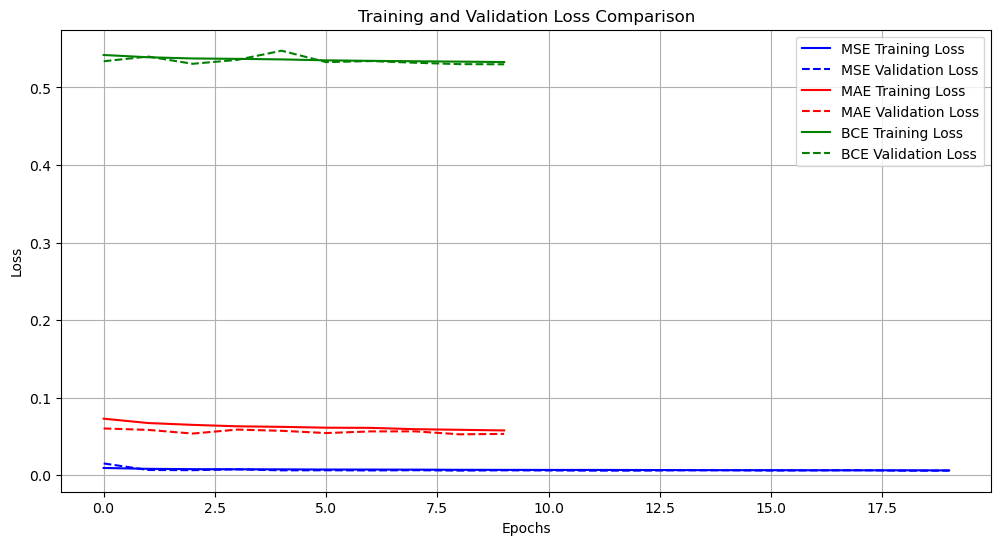

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load the histories from .npy files
history_mse = np.load("history_mse.npy", allow_pickle=True).item()
history_mae = np.load("history_mae.npy", allow_pickle=True).item()
history_bce = np.load("history_bce.npy", allow_pickle=True).item()

# Plot training and validation loss for each model
plt.figure(figsize=(12, 6))

# Plot for MSE model
plt.plot(history_mse['loss'], label='MSE Training Loss', color='blue')
plt.plot(history_mse['val_loss'], label='MSE Validation Loss', linestyle='dashed', color='blue')

# Plot for MAE model
plt.plot(history_mae['loss'], label='MAE Training Loss', color='red')
plt.plot(history_mae['val_loss'], label='MAE Validation Loss', linestyle='dashed', color='red')

# Plot for Binary Crossentropy model
plt.plot(history_bce['loss'], label='BCE Training Loss', color='green')
plt.plot(history_bce['val_loss'], label='BCE Validation Loss', linestyle='dashed', color='green')

# Customize plot
plt.title("Training and Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
